In [1]:
from utils import *
import pandas as pd
import numpy as np

In [2]:
train = load_product('train','BANANAS')
val = load_product('val', 'BANANAS')
val.head()

,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,spread,lr
1,0,BANANAS,4871,9,4870.0,23.0,NaN,NaN,4877,23,NaN,NaN,NaN,NaN,4874.0,0.000000,6,0.000410
4,100,BANANAS,4875,1,4871.0,4.0,4870.0,22.0,4877,22,NaN,NaN,NaN,NaN,4876.0,0.000000,2,-0.000615
8,200,BANANAS,4870,22,NaN,NaN,NaN,NaN,4876,22,NaN,NaN,NaN,NaN,4873.0,1.966309,6,0.000205
12,300,BANANAS,4873,1,4868.0,26.0,NaN,NaN,4875,26,NaN,NaN,NaN,NaN,4874.0,8.063477,2,-0.000718
17,400,BANANAS,4870,8,4869.0,28.0,NaN,NaN,4871,5,4875.0,28.0,NaN,NaN,4870.5,8.017578,1,0.000821


In [6]:
window = 1000
train['moving_average'] = train['mid_price'].rolling(window=window).mean()

In [4]:
train.head()

,timestamp,day,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,spread,lr,moving_average
3,0,-1,BANANAS,4951,1,4946.0,2.0,4945.0,29.0,4952,31,NaN,NaN,NaN,NaN,4951.5,0.000000,1,-0.000606,NaN
7,100,-1,BANANAS,4945,24,NaN,NaN,NaN,NaN,4952,24,NaN,NaN,NaN,NaN,4948.5,3.444336,7,0.000000,NaN
9,200,-1,BANANAS,4945,20,NaN,NaN,NaN,NaN,4952,20,NaN,NaN,NaN,NaN,4948.5,3.795410,7,0.000000,NaN
15,300,-1,BANANAS,4945,31,NaN,NaN,NaN,NaN,4952,31,NaN,NaN,NaN,NaN,4948.5,3.604004,7,0.000000,NaN
19,400,-1,BANANAS,4945,27,NaN,NaN,NaN,NaN,4952,27,NaN,NaN,NaN,NaN,4948.5,3.337402,7,-0.000202,NaN


<Axes: >

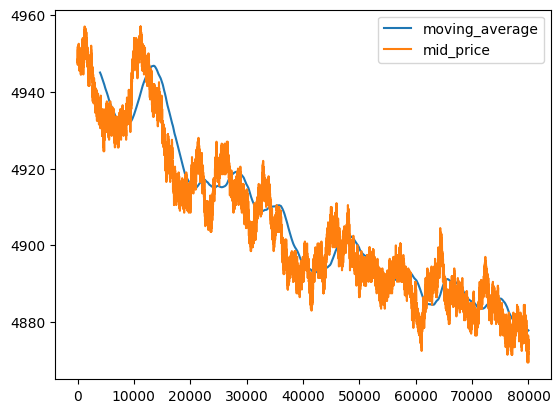

In [7]:
train.plot(y=['moving_average', 'mid_price'])

In [8]:
from pycopula.copula import ArchimedeanCopula

# Calculate the rank of the price and moving average
train['price_rank'] = train['mid_price'].rank(pct=True)
train['moving_average_rank'] = train['moving_average'].rank(pct=True)

train.head()

,timestamp,day,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,spread,lr,moving_average,price_rank,moving_average_rank
3,0,-1,BANANAS,4951,1,4946.0,2.0,4945.0,29.0,4952,...,NaN,NaN,NaN,4951.5,0.000000,1,-0.000606,NaN,0.98750,NaN
7,100,-1,BANANAS,4945,24,NaN,NaN,NaN,NaN,4952,...,NaN,NaN,NaN,4948.5,3.444336,7,0.000000,NaN,0.96265,NaN
9,200,-1,BANANAS,4945,20,NaN,NaN,NaN,NaN,4952,...,NaN,NaN,NaN,4948.5,3.795410,7,0.000000,NaN,0.96265,NaN
15,300,-1,BANANAS,4945,31,NaN,NaN,NaN,NaN,4952,...,NaN,NaN,NaN,4948.5,3.604004,7,0.000000,NaN,0.96265,NaN
19,400,-1,BANANAS,4945,27,NaN,NaN,NaN,NaN,4952,...,NaN,NaN,NaN,4948.5,3.337402,7,-0.000202,NaN,0.96265,NaN


In [10]:
# Fit a copula to the ranked data
copula = ArchimedeanCopula("clayton")
copula.fit(train[['price_rank', 'moving_average_rank']].to_numpy())

# Calculate the copula density for each observation
train['copula_density'] = copula.pdf(train[['price_rank', 'moving_average_rank']].to_numpy())

train.head()

ValueError: Expected vector of dimension 2, get vector of dimension 20000

In [12]:
copula.pdf(train.iloc[1001][['price_rank', 'moving_average_rank']])

2.6049628334992305

In [13]:
copula.partial_derivative(*)

AttributeError: 'ArchimedeanCopula' object has no attribute 'partial_derivative'

In [ ]:
# Define the threshold for trading based on the copula density
threshold = 0.95

# Create a function to generate trading signals
def generate_signals(df, threshold):
    signal = 0
    if df['copula_density'] > threshold:
        if df['price'] < df['moving_average']:
            signal = 1  # Buy signal
        elif df['price'] > df['moving_average']:
            signal = -1  # Sell signal
    return signal

# Apply the function to the data
data['signal'] = data.apply(generate_signals, args=(threshold,), axis=1)

# Calculate the positions
data['position'] = data['signal'].cumsum()

# The 'position' column now contains the current position of the stock (1 for long, -1 for short, 0 for neutral)